In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import geopandas
import subprocess
import numpy as np
import libpysal as lp
from shapely.geometry import mapping
from shapely.ops import unary_union
import folium

graph

In [9]:
"""
The MIT License (MIT)

Copyright (c) 2016 Christian August Reksten-Monsen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""
from collections import defaultdict


class Point(object):
    __slots__ = ('x', 'y', 'z', 'polygon_id')

    def __init__(self, x, y, z=[None, None], polygon_id=-1):
        self.x = float(x)
        self.y = float(y)
        self.z = z
        self.polygon_id = polygon_id

    def __eq__(self, point):
        return point and self.x == point.x and self.y == point.y

    def __ne__(self, point):
        return not self.__eq__(point)

    def __lt__(self, point):
        """ This is only needed for shortest path calculations where heapq is
            used. When there are two points of equal distance, heapq will
            instead evaluate the Points, which doesnt work in Python 3 and
            throw a TypeError."""
        return hash(self) < hash(point)

    def __str__(self):
        return "(%.2f, %.2f)" % (self.x, self.y)

    def __hash__(self):
        return self.x.__hash__() ^ self.y.__hash__()

    def __repr__(self):
        return "Point(%.2f, %.2f)" % (self.x, self.y)


class Edge(object):
    __slots__ = ('p1', 'p2')

    def __init__(self, point1, point2):
        self.p1 = point1
        self.p2 = point2

    def get_adjacent(self, point):
        if point == self.p1:
            return self.p2
        return self.p1

    def __contains__(self, point):
        return self.p1 == point or self.p2 == point

    def __eq__(self, edge):
        if self.p1 == edge.p1 and self.p2 == edge.p2:
            return True
        if self.p1 == edge.p2 and self.p2 == edge.p1:
            return True
        return False

    def __ne__(self, edge):
        return not self.__eq__(edge)

    def __str__(self):
        return "({}, {})".format(self.p1, self.p2)

    def __repr__(self):
        return "Edge({!r}, {!r})".format(self.p1, self.p2)

    def __hash__(self):
        return self.p1.__hash__() ^ self.p2.__hash__()


class Graph(object):
    """
    A Graph is represented by a dict where the keys are Points in the Graph
    and the dict values are sets containing Edges incident on each Point.
    A separate set *edges* contains all Edges in the graph.

    The input must be a list of polygons, where each polygon is a list of
    in-order (clockwise or counter clockwise) Points. If only one polygon,
    it must still be a list in a list, i.e. [[Point(0,0), Point(2,0),
    Point(2,1)]].

    *polygons* dictionary: key is a integer polygon ID and values are the
    edges that make up the polygon. Note only polygons with 3 or more Points
    will be classified as a polygon. Non-polygons like just one Point will be
    given a polygon ID of -1 and not maintained in the dict.
    """

    def __init__(self, polygons):
        self.graph = defaultdict(set)
        self.edges = set()
        self.polygons = defaultdict(set)
        pid = 0
        for polygon in polygons:
            if polygon[0] == polygon[-1] and len(polygon) > 1:
                polygon.pop()
            for i, point in enumerate(polygon):
                sibling_point = polygon[(i + 1) % len(polygon)]
                edge = Edge(point, sibling_point)
                if len(polygon) > 2:
                    point.polygon_id = pid
                    sibling_point.polygon_id = pid
                    self.polygons[pid].add(edge)
                self.add_edge(edge)
            if len(polygon) > 2:
                pid += 1

    def get_adjacent_points(self, point):
        return [edge.get_adjacent(point) for edge in self[point]]

    def get_points(self):
        return list(self.graph)

    def get_edges(self):
        return self.edges

    def add_edge(self, edge):
        self.graph[edge.p1].add(edge)
        self.graph[edge.p2].add(edge)
        self.edges.add(edge)

    def __contains__(self, item):
        if isinstance(item, Point):
            return item in self.graph
        if isinstance(item, Edge):
            return item in self.edges
        return False

    def __getitem__(self, point):
        if point in self.graph:
            return self.graph[point]
        return set()

    def __str__(self):
        res = ""
        for point in self.graph:
            res += "\n" + str(point) + ": "
            for edge in self.graph[point]:
                res += str(edge)
        return res

    def __repr__(self):
        return self.__str__()


visible_vertices

In [10]:
"""
The MIT License (MIT)

Copyright (c) 2016 Christian August Reksten-Monsen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""
from __future__ import division
from math import pi, sqrt, atan, acos

INF = 10000
"""Due to floating point representation error, some functions need to
   truncate floating point numbers to a certain tolerance."""
COLIN_TOLERANCE = 13
T = 10**COLIN_TOLERANCE
T2 = 10.0**COLIN_TOLERANCE

def visible_vertices(point, graph, origin=None, destination=None, scan='full'):
    """Returns list of Points in graph visible by point.

    If origin and/or destination Points are given, these will also be checked
    for visibility. scan 'full' will check for visibility against all points in
    graph, 'half' will check for visibility against half the points. This saves
    running time when building a complete visibility graph, as the points
    that are not checked will eventually be 'point'.
    """
    edges = graph.get_edges()
    points = graph.get_points()
    if origin: points.append(origin)
    if destination: points.append(destination)
    points.sort(key=lambda p: (angle(point, p), edge_distance(point, p)))

    # Initialize open_edges with any intersecting edges on the half line from
    # point along the positive x-axis
    open_edges = []
    point_inf = Point(INF, point.y)
    for e in edges:
        if point in e: continue
        if edge_intersect(point, point_inf, e):
            if on_segment(point, e.p1, point_inf): continue
            if on_segment(point, e.p2, point_inf): continue
            k = EdgeKey(point, point_inf, e)
            insort(open_edges, k)

    visible = []
    prev = None
    prev_visible = None
    for p in points:
        if p == point: continue
        if scan == 'half' and angle(point, p) > pi: break

        # Remove clock wise edges incident on p
        if open_edges:
            for edge in graph[p]:
                if ccw(point, p, edge.get_adjacent(p)) == -1:
                    k = EdgeKey(point, p, edge)
                    index = bisect(open_edges, k) - 1
                    if len(open_edges) > 0 and open_edges[index] == k:
                        del open_edges[index]

        # Check if p is visible from point
        is_visible = False
        # ...Non-collinear points
        if prev is None or ccw(point, prev, p) != 0 or not on_segment(point, prev, p):
            if len(open_edges) == 0:
                is_visible = True
            elif not edge_intersect(point, p, open_edges[0].edge):
                is_visible = True
        # ...For collinear points, if previous point was not visible, p is not
        elif not prev_visible:
            is_visible = False
        # ...For collinear points, if previous point was visible, need to check
        # that the edge from prev to p does not intersect any open edge.
        else:
            is_visible = True
            for e in open_edges:
                if prev not in e.edge and edge_intersect(prev, p, e.edge):
                    is_visible = False
                    break
            if is_visible and edge_in_polygon(prev, p, graph):
                    is_visible = False

        # Check if the visible edge is interior to its polygon
        if is_visible and p not in graph.get_adjacent_points(point):
            is_visible = not edge_in_polygon(point, p, graph)

        if is_visible: visible.append(p)

        # Add counter clock wise edges incident on p to open_edges
        for edge in graph[p]:
            if (point not in edge) and ccw(point, p, edge.get_adjacent(p)) == 1:
                k = EdgeKey(point, p, edge)
                insort(open_edges, k)

        prev = p
        prev_visible = is_visible
    return visible


def polygon_crossing(p1, poly_edges):
    """Returns True if Point p1 is internal to the polygon The polygon is
    defined by the Edges in poly_edges. Uses crossings algorithm and takes into
    account edges that are collinear to p1."""
    p2 = Point(INF, p1.y)
    intersect_count = 0
    co_flag = False
    co_dir = 0
    for edge in poly_edges:
        if p1.y < edge.p1.y and p1.y < edge.p2.y: continue
        if p1.y > edge.p1.y and p1.y > edge.p2.y: continue
        # Deal with points colinear to p1
        co0 = (ccw(p1, edge.p1, p2) == 0) and (edge.p1.x > p1.x)
        co1 = (ccw(p1, edge.p2, p2) == 0) and (edge.p2.x > p1.x)
        if co0 and co1: continue
        co_point = edge.p1 if co0 else edge.p2
        if co0 or co1:
            if edge.get_adjacent(co_point).y > p1.y:
                co_dir += 1
            else:
                co_dir -= 1
            if co_flag:
                if co_dir == 0:
                    intersect_count += 1
                co_flag = False
                co_dir = 0
            else:
                co_flag = True
        elif edge_intersect(p1, p2, edge):
            intersect_count += 1
    if intersect_count % 2 == 0:
        return False
    return True


def edge_in_polygon(p1, p2, graph):
    if p1.polygon_id != p2.polygon_id:
        return False
    if p1.polygon_id == -1 or p2.polygon_id == -1:
        return False
    mid_point = Point((p1.x + p2.x) / 2, (p1.y + p2.y) / 2)
    return polygon_crossing(mid_point, graph.polygons[p1.polygon_id])


def point_in_polygon(p, graph):
    for polygon in graph.polygons:
        if polygon_crossing(p, graph.polygons[polygon]):
            return polygon
    return -1


def unit_vector(c, p):
    magnitude = edge_distance(c, p)
    return Point((p.x - c.x) / magnitude, (p.y - c.y) / magnitude)


def closest_point(p, graph, polygon_id, length=0.001):
    """Assumes p is interior to the polygon with polygon_id. Returns the
    closest point c outside the polygon to p, where the distance from c to
    the intersect point from p to the edge of the polygon is length."""
    polygon_edges = graph.polygons[polygon_id]
    close_point = None
    close_edge = None
    close_dist = None
    # Finds point closest to p, but on a edge of the polygon.
    # Solution from http://stackoverflow.com/a/6177788/4896361
    for i, e in enumerate(polygon_edges):
        num = ((p.x-e.p1.x)*(e.p2.x-e.p1.x) + (p.y-e.p1.y)*(e.p2.y-e.p1.y))
        denom = ((e.p2.x - e.p1.x)**2 + (e.p2.y - e.p1.y)**2)
        u = num/denom
        pu = Point(e.p1.x + u*(e.p2.x - e.p1.x), e.p1.y + u*(e.p2.y- e.p1.y))
        pc = pu
        if u < 0:
            pc = e.p1
        elif u > 1:
            pc = e.p2
        d = edge_distance(p, pc)
        if i == 0 or d < close_dist:
            close_dist = d
            close_point = pc
            close_edge = e

    # Extend the newly found point so it is outside the polygon by `length`.
    if close_point in close_edge:
        c = close_edge.p1 if close_point == close_edge.p1 else close_edge.p2
        edges = list(graph[c])
        v1 = unit_vector(c, edges[0].get_adjacent(c))
        v2 = unit_vector(c, edges[1].get_adjacent(c))
        vsum = unit_vector(Point(0, 0), Point(v1.x + v2.x, v1.y + v2.y))
        close1 = Point(c.x + (vsum.x * length), c.y + (vsum.y * length))
        close2 = Point(c.x - (vsum.x * length), c.y - (vsum.y * length))
        if point_in_polygon(close1, graph) == -1:
            return close1
        return close2
    else:
        v = unit_vector(p, close_point)
        return Point(close_point.x + v.x*length, close_point.y + v.y*length)


def edge_distance(p1, p2):
    """Return the Euclidean distance between two Points."""
    return sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)


def intersect_point(p1, p2, edge):
    """Return intersect Point where the edge from p1, p2 intersects edge"""
    if p1 in edge: return p1
    if p2 in edge: return p2
    if edge.p1.x == edge.p2.x:
        if p1.x == p2.x:
            return None
        pslope = (p1.y - p2.y) / (p1.x - p2.x)
        intersect_x = edge.p1.x
        intersect_y = pslope * (intersect_x - p1.x) + p1.y
        return Point(intersect_x, intersect_y)

    if p1.x == p2.x:
        eslope = (edge.p1.y - edge.p2.y) / (edge.p1.x - edge.p2.x)
        intersect_x = p1.x
        intersect_y = eslope * (intersect_x - edge.p1.x) + edge.p1.y
        return Point(intersect_x, intersect_y)

    pslope = (p1.y - p2.y) / (p1.x - p2.x)
    eslope = (edge.p1.y - edge.p2.y) / (edge.p1.x - edge.p2.x)
    if eslope == pslope:
        return None
    intersect_x = (eslope * edge.p1.x - pslope * p1.x + p1.y - edge.p1.y) / (eslope - pslope)
    intersect_y = eslope * (intersect_x - edge.p1.x) + edge.p1.y
    return Point(intersect_x, intersect_y)


def point_edge_distance(p1, p2, edge):
    """Return the Eucledian distance from p1 to intersect point with edge.
    Assumes the line going from p1 to p2 intersects edge before reaching p2."""
    ip = intersect_point(p1, p2, edge)
    if ip is not None:
        return edge_distance(p1, ip)
    return 0


def angle(center, point):
    """Return the angle (radian) of point from center of the radian circle.
     ------p
     |   /
     |  /
    c|a/
    """
    dx = point.x - center.x
    dy = point.y - center.y
    if dx == 0:
        if dy < 0:
            return pi * 3 / 2
        return pi / 2
    if dy == 0:
        if dx < 0:
            return pi
        return 0
    if dx < 0:
        return pi + atan(dy / dx)
    if dy < 0:
        return 2 * pi + atan(dy / dx)
    return atan(dy / dx)


def angle2(point_a, point_b, point_c):
    """Return angle B (radian) between point_b and point_c.
           c
         /  \
       /    B\
      a-------b
    """
    a = (point_c.x - point_b.x)**2 + (point_c.y - point_b.y)**2
    b = (point_c.x - point_a.x)**2 + (point_c.y - point_a.y)**2
    c = (point_b.x - point_a.x)**2 + (point_b.y - point_a.y)**2
    cos_value = (a + c - b) / (2 * sqrt(a) * sqrt(c))
    return acos(int(cos_value*T)/T2)


def ccw(A, B, C):
    """Return 1 if counter clockwise, -1 if clock wise, 0 if collinear """
    #  Rounding this way is faster than calling round()
    area = int(((B.x - A.x) * (C.y - A.y) - (B.y - A.y) * (C.x - A.x))*T)/T2
    if area > 0: return 1
    if area < 0: return -1
    return 0


def on_segment(p, q, r):
    """Given three colinear points p, q, r, the function checks if point q
    lies on line segment 'pr'."""
    if (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)):
        if (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y)):
            return True
    return False


def edge_intersect(p1, q1, edge):
    """Return True if edge from A, B interects edge.
    http://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/"""
    p2 = edge.p1
    q2 = edge.p2
    o1 = ccw(p1, q1, p2)
    o2 = ccw(p1, q1, q2)
    o3 = ccw(p2, q2, p1)
    o4 = ccw(p2, q2, q1)

    # General case
    if (o1 != o2 and o3 != o4):
        return True
    # p1, q1 and p2 are colinear and p2 lies on segment p1q1
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    # p1, q1 and p2 are colinear and q2 lies on segment p1q1
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    # p2, q2 and p1 are colinear and p1 lies on segment p2q2
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    # p2, q2 and q1 are colinear and q1 lies on segment p2q2
    if o4 == 0 and on_segment(p2, q1, q2):
        return True
    return False


def insort(a, x):
    lo = 0
    hi = len(a)
    while lo < hi:
        mid = (lo+hi)//2
        if x < a[mid]: hi = mid
        else: lo = mid+1
    a.insert(lo, x)


def bisect(a, x):
    lo = 0
    hi = len(a)
    while lo < hi:
        mid = (lo+hi)//2
        if x < a[mid]: hi = mid
        else: lo = mid+1
    return lo


class EdgeKey(object):
    def __init__(self, p1, p2, edge):
        self.p1 = p1
        self.p2 = p2
        self.edge = edge

    def __eq__(self, other):
        if self.edge == other.edge:
            return True

    def __lt__(self, other):
        if self.edge == other.edge:
            return False
        if not edge_intersect(self.p1, self.p2, other.edge):
            return True
        self_dist = point_edge_distance(self.p1, self.p2, self.edge)
        other_dist = point_edge_distance(self.p1, self.p2, other.edge)
        if self_dist > other_dist:
            return False
        if self_dist < other_dist:
            return True
        # If the distance is equal, we need to compare on the edge angles.
        if self_dist == other_dist:
            if self.edge.p1 in other.edge:
                same_point = self.edge.p1
            elif self.edge.p2 in other.edge:
                same_point = self.edge.p2
            aslf = angle2(self.p1, self.p2, self.edge.get_adjacent(same_point))
            aot = angle2(self.p1, self.p2, other.edge.get_adjacent(same_point))
            if aslf < aot:
                return True
            return False

    def __repr__(self):
        reprstring = (self.__class__.__name__, self.edge, self.p1, self.p2)
        return "{}(Edge={!r}, p1={!r}, p2={!r})".format(*reprstring)


shortest_path

In [11]:
"""
The MIT License (MIT)

Copyright (c) 2016 Christian August Reksten-Monsen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""
from heapq import heapify, heappush, heappop

try:
    dict.iteritems
except AttributeError:
    # Python 3
    def iteritems(d):
        return iter(d.items())
else:
    # Python 2
    def iteritems(d):
        return d.iteritems()


def dijkstra(graph, origin, destination, add_to_visgraph):
    D = {}
    P = {}
    Q = priority_dict()
    Q[origin] = 0

    for v in Q:
        D[v] = Q[v]
        if v == destination: break
        edges = graph[v]
        if add_to_visgraph != None and len(add_to_visgraph[v]) > 0:
            edges = add_to_visgraph[v] | graph[v]
        for e in edges:
            w = e.get_adjacent(v)
            elength = D[v] + edge_distance(v, w)
            if w in D:
                if elength < D[w]:
                    raise ValueError
            elif w not in Q or elength < Q[w]:
                Q[w] = elength
                P[w] = v
    return (D, P)


def shortest_path(graph, origin, destination, add_to_visgraph=None):
    D, P = dijkstra(graph, origin, destination, add_to_visgraph)
    path = []
    while 1:
        path.append(destination)
        if destination == origin: break
        destination = P[destination]
    path.reverse()
    return path


class priority_dict(dict):
    """Dictionary that can be used as a priority queue.

    Keys of the dictionary are items to be put into the queue, and values
    are their respective priorities. All dictionary methods work as expected.
    The advantage over a standard heapq-based priority queue is that priorities
    of items can be efficiently updated (amortized O(1)) using code as
    'thedict[item] = new_priority.'

    Note that this is a modified version of
    https://gist.github.com/matteodellamico/4451520 where sorted_iter() has
    been replaced with the destructive sorted iterator __iter__ from
    https://gist.github.com/anonymous/4435950
    """
    def __init__(self, *args, **kwargs):
        super(priority_dict, self).__init__(*args, **kwargs)
        self._rebuild_heap()

    def _rebuild_heap(self):
        self._heap = [(v, k) for k, v in iteritems(self)]
        heapify(self._heap)

    def smallest(self):
        heap = self._heap
        v, k = heap[0]
        while k not in self or self[k] != v:
            heappop(heap)
            v, k = heap[0]
        return k

    def pop_smallest(self):
        heap = self._heap
        v, k = heappop(heap)
        while k not in self or self[k] != v:
            v, k = heappop(heap)
        del self[k]
        return k

    def __setitem__(self, key, val):
        super(priority_dict, self).__setitem__(key, val)

        if len(self._heap) < 2 * len(self):
            heappush(self._heap, (val, key))
        else:
            self._rebuild_heap()

    def setdefault(self, key, val):
        if key not in self:
            self[key] = val
            return val
        return self[key]

    def update(self, *args, **kwargs):
        super(priority_dict, self).update(*args, **kwargs)
        self._rebuild_heap()

    def __iter__(self):
        def iterfn():
            while len(self) > 0:
                x = self.smallest()
                yield x
                del self[x]
        return iterfn()


vis_graph

In [12]:
"""
The MIT License (MIT)

Copyright (c) 2016 Christian August Reksten-Monsen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""
from timeit import default_timer
from sys import stdout, version_info
from multiprocessing import Pool
from tqdm import tqdm
from warnings import warn


PYTHON3 = version_info[0] == 3
if PYTHON3:
    xrange = range
    import pickle
else:
    import cPickle as pickle


class VisGraph(object):

    def __init__(self):
        self.graph = None
        self.visgraph = None

    def load(self, filename):
        """Load obstacle graph and visibility graph. """
        with open(filename, 'rb') as load:
            self.graph, self.visgraph = pickle.load(load)

    def save(self, filename):
        """Save obstacle graph and visibility graph. """
        with open(filename, 'wb') as output:
            pickle.dump((self.graph, self.visgraph), output, -1)

    def build(self, input, workers=1, status=True): 
        """Build visibility graph based on a list of polygons.

        The input must be a list of polygons, where each polygon is a list of
        in-order (clockwise or counter clockwise) Points. It only one polygon,
        it must still be a list in a list, i.e. [[Point(0,0), Point(2,0),
        Point(2,1)]].
        Take advantage of processors with multiple cores by setting workers to
        the number of subprocesses you want. Defaults to 1, i.e. no subprocess
        will be started.
        Set status=False to turn off the statusbar when building.
        """

        self.graph = Graph(input)
        self.visgraph = Graph([])

        points = self.graph.get_points()
        batch_size = 10 

        if workers == 1:
            for batch in tqdm([points[i:i + batch_size]
                               for i in xrange(0, len(points), batch_size)],
                            disable=not status):
                for edge in _vis_graph(self.graph, batch):
                    self.visgraph.add_edge(edge)
        else:
            pool = Pool(workers)
            batches = [(self.graph, points[i:i + batch_size])
                       for i in xrange(0, len(points), batch_size)]

            results = list(tqdm(pool.imap(_vis_graph_wrapper, batches), total=len(batches),
                disable=not status))
            for result in results:
                for edge in result:
                    self.visgraph.add_edge(edge)

    def find_visible(self, point):
        """Find vertices visible from point."""

        return visible_vertices(point, self.graph)

    def update(self, points, origin=None, destination=None):
        """Update visgraph by checking visibility of Points in list points."""

        for p in points:
            for v in visible_vertices(p, self.graph, origin=origin,
                                      destination=destination):
                self.visgraph.add_edge(Edge(p, v))

    def shortest_path(self, origin, destination):
        """Find and return shortest path between origin and destination.

        Will return in-order list of Points of the shortest path found. If
        origin or destination are not in the visibility graph, their respective
        visibility edges will be found, but only kept temporarily for finding
        the shortest path. 
        """

        origin_exists = origin in self.visgraph
        dest_exists = destination in self.visgraph
        if origin_exists and dest_exists:
            return shortest_path(self.visgraph, origin, destination)
        orgn = None if origin_exists else origin
        dest = None if dest_exists else destination
        add_to_visg = Graph([])
        if not origin_exists:
            for v in visible_vertices(origin, self.graph, destination=dest):
                add_to_visg.add_edge(Edge(origin, v))
        if not dest_exists:
            for v in visible_vertices(destination, self.graph, origin=orgn):
                add_to_visg.add_edge(Edge(destination, v))
        return shortest_path(self.visgraph, origin, destination, add_to_visg)

    def point_in_polygon(self, point):
        """Return polygon_id if point in a polygon, -1 otherwise."""

        return point_in_polygon(point, self.graph)

    def closest_point(self, point, polygon_id, length=0.001):
        """Return closest Point outside polygon from point.

        Note method assumes point is inside the polygon, no check is
        performed.
        """

        return closest_point(point, self.graph, polygon_id, length)


def _vis_graph_wrapper(args):
    try:
        return _vis_graph(*args)
    except KeyboardInterrupt:
        pass

def _vis_graph(graph, points):
    visible_edges = []
    for p1 in points:
        for p2 in visible_vertices(p1, graph, scan='half'):
            visible_edges.append(Edge(p1, p2))
    return visible_edges


In [13]:
nush: geopandas.GeoDataFrame = geopandas.read_file("../data/josm/main.geojson")
nush['level'] = nush['level'].apply(lambda x: x.split("-") if x.find("-")!=-1 else [x,x])
nush['indoor'] = nush['indoor'].fillna(nush['highway'])
neighbor = lp.weights.Queen.from_dataframe(nush, use_index=False)
nush['neighbor'] = neighbor.to_adjlist(drop_islands=True).groupby("focal").agg(list)['neighbor']
nush.reset_index(inplace=True)
nush

c:\Users\picokatx\Documents\pathfinding-project\pathfinding-project\.venv\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 61, 139, 758.
  W.__init__(self, neighbors, ids=ids, **kw)


,index,crossing,door,access,name,amenity,landuse,traversal,service,utility,indoor,level,lanes:forward,lanes:backward,highway,oneway,lanes,geometry,neighbor
0,0,None,no,yes,None,None,None,None,None,None,None,"[2, 2]",None,None,None,None,None,"LINESTRING (103.76926 1.30635, 103.76926 1.30634)","[34, 220, 237, 282, 829, 879, 950]"
1,1,None,None,None,Parking,None,parking,None,None,None,area,"[1, 1]",None,None,None,None,None,"POLYGON ((103.76936 1.30574, 103.76936 1.30570...",[71]
2,2,unmarked,None,None,None,None,None,None,None,None,corridor,"[1, 1]",None,None,None,None,None,"POLYGON ((103.76935 1.30571, 103.76916 1.30575...","[71, 365, 640]"
3,3,None,no,yes,None,None,None,None,None,None,None,"[2, 2]",None,None,None,None,None,"LINESTRING (103.77026 1.30763, 103.77027 1.30761)",[376]
4,4,None,None,None,None,None,None,None,None,None,corridor,"[5, 5]",None,None,None,None,None,"POLYGON ((103.76918 1.30737, 103.76918 1.30736...","[10, 69, 79, 83, 172, 173, 197, 229, 249, 295,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,1038,None,None,None,Auditorium,events_venue,None,None,None,None,wall,"[4, 6]",None,None,None,None,None,"LINESTRING (103.76947 1.30748, 103.76944 1.307...","[29, 50, 56, 86, 92, 114, 170, 185, 194, 197, ..."
1039,1039,None,yes,yes,None,None,None,None,None,None,None,"[3, 3]",None,None,None,None,None,"POLYGON ((103.76979 1.30765, 103.76980 1.30765...","[389, 405]"
1040,1040,None,yes,yes,None,None,None,None,None,None,None,"[2, 2]",None,None,None,None,None,"POLYGON ((103.76941 1.30628, 103.76941 1.30627...","[72, 150, 157, 182, 235, 539]"
1041,1041,None,no,yes,None,None,None,None,None,None,None,"[6, 6]",None,None,None,None,None,"LINESTRING (103.76927 1.30747, 103.76926 1.30747)","[79, 595, 725, 755]"


In [28]:

f = folium.Figure(width=960, height=600)
level_start = 1
level_end  =  1
polys = []
for level in range(level_start,level_end+1):
    elm = nush[((level>=nush['level'].str[0].astype(float)) & (level<=nush['level'].str[1].astype(float)))
        & (
            (nush['indoor']=='corridor') | 
            (nush['indoor']=='area') |
            (nush['indoor']=='steps') | 
            (nush['indoor']=='elevator')
            # ((nush['access']=='yes') & (nush['door']=='no'))
        )
        & (nush['landuse']!="void")
         & ((nush['landuse']=="void_deck") | (nush['landuse'].isna()))
    ]

    minx, miny, maxx, maxy = elm.bounds['minx'].min()+1e-6, elm.bounds['miny'].min()+1e-6, elm.bounds['maxx'].max()-1e-6, elm.bounds['maxy'].max()-1e-6
    bounds = shapely.geometry.polygon.Polygon([[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]])
    for poly in list(bounds.difference(unary_union(elm['geometry'])).geoms): #elm['geometry']:
        for ptdb in mapping(poly)['coordinates']:
            polys.append([Point(pt[0], pt[1], [level, level]) for pt in ptdb])

highways = nush[((level>=nush['level'].str[0].astype(float)) & (level<=nush['level'].str[1].astype(float)))
    & (
        (nush['indoor']=='steps') | 
        (nush['indoor']=='elevator')
    )
]
tempi = 0
for h in highways.itertuples():
    if (tempi==3):
        tempi+=1
        continue
    l = h.level
    geom = h.geometry
    polys.append([Point(pt[0], pt[1], l) for pt in mapping(geom)['coordinates'][0]])
    tempi+=1
    # if (tempi>=7): break

# polys.append([Point(103.7688802, 1.3063082), Point(103.7689068, 1.3063082)])
g = VisGraph()
g.build(polys)

start_point = Point(103.7688753, 1.3063346, 1)
end_point = Point(103.7707549, 1.3067671, 1)
#103.7690985, 1.3070299
#103.7689985, 1.3071000 (block B rear stairway)
#103.7707549, 1.3067671 (road to boarding)
wayfind = g.shortest_path(start_point, end_point)

geopath = [[point.y, point.x] for point in wayfind]
layout = [[[point.y, point.x] for point in poly] for poly in polys]


geomap  = folium.Map([0, 0], width="100%", height="100%").add_to(f)
geomap.fit_bounds([[1.3055, 0.0685+103.7], [1.3080, 0.0710+103.7]])

for poly in layout:
    folium.Polygon(poly, fill_color="red").add_to(geomap)
folium.PolyLine(geopath, color="red").add_to(geomap)
f

100%|██████████| 95/95 [00:38<00:00,  2.46it/s]


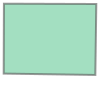

In [22]:
highways.iloc[3]['geometry']